In [2]:
!pip install iterative-stratification
!pip install wfdb

In [3]:
#LIBERIAS
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import re
import wfdb
from tabulate import tabulate
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import scipy

#model libraries
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from keras import layers
#from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalMaxPooling1D, Dense, Dropout, Permute, Reshape
import tensorflow as tf
import keras
from keras import models, layers
from keras.layers import concatenate
import tensorflow as tf
import keras
from keras import models, layers


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from sklearn.model_selection import StratifiedShuffleSplit
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from sklearn.metrics import f1_score
import numpy as np
from keras.models import clone_model
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#ACCEDIENDO A LOS DATOS..

#Conexión al drive
data_path = "/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales normales/Datos_h5 y HEA"

###Visualización y tratamiento de datos

In [6]:
# Se obtiene la lista de archivos .MAT Ty .HEA de la carpeta
file_list_h5 = [file for file in os.listdir(data_path) if file.endswith('.h5')]
file_list_hea = [file for file in os.listdir(data_path) if file.endswith('.hea')]

# Función parar ordenar por número las señales
def sort_by_numbers(file_name):
    # Se ordena por los tres números del interior del nombre del dato
    numbers = re.findall(r'\d{3}', file_name)
    return int(numbers[0])

# Se ordena la lista
sorted_file_list_h5 = sorted(file_list_h5, key=sort_by_numbers)
sorted_file_list_hea = sorted(file_list_hea, key=sort_by_numbers)

# Se ordenan por número
sorted_file_paths_h5 = [os.path.join(data_path, file) for file in sorted_file_list_h5]
sorted_file_paths_hea = [os.path.join(data_path, file[:-4]) for file in sorted_file_list_hea]

In [15]:
# Establecer la semilla para reproducibilidad
np.random.seed(42)

# Inicializar listas para datos
data_first_part = []
data_second_part = []

# Definir la longitud para ambas partes (10 segundos)
length_first_part = 10 * 250  # 10 segundos en muestras a 250 Hz
length_second_part = 10 * 250  # 10 segundos en muestras a 250 Hz

# Procesar registros
for file_path in sorted_file_paths_h5:
    # Cargar el archivo h5
    with h5py.File(file_path, 'r') as file:
        # Obtener las señales del archivo h5
        signals = file['val'][:]

    # Verificar si el registro tiene menos de 4 señales
    while signals.shape[0] < 4:
        # Crear una señal de ceros de la misma longitud que las otras señales
        zero_signal = np.zeros((1, signals.shape[1]))
        # Agregar la señal de ceros a las señales existentes
        signals = np.vstack((signals, zero_signal))

    # Verificar si la señal es más larga que la longitud deseada para la primera parte
    if signals.shape[1] > length_first_part:
        # Tomar un segmento aleatorio de 10 segundos dentro de la primera parte de la señal
        start_index_first_part = np.random.randint(0, signals.shape[1] - length_first_part + 1)
        signals_first_part = signals[:, start_index_first_part:start_index_first_part + length_first_part]
    else:
        # Si la señal es más corta que la longitud deseada, agregar ceros al principio
        signals_first_part = np.zeros((signals.shape[0], length_first_part))
        signals_first_part[:, :signals.shape[1]] = signals

    # Obtener la segunda parte de la señal (últimos 10 segundos)
    signals_second_part = signals[:, -length_second_part:]

    # Agregar las partes de las señales a las listas correspondientes
    data_first_part.append(signals_first_part)
    data_second_part.append(signals_second_part)

# Convertir las listas de datos a arrays numpy
data_first_part = np.array(data_first_part)
data_second_part = np.array(data_second_part)

# Verificar el número de datos en cada parte
print("Número de registros procesados (Primera parte):", len(data_first_part))
print("Número de registros procesados (Segunda parte):", len(data_second_part))

Número de registros procesados (Primera parte): 750
Número de registros procesados (Segunda parte): 750


In [16]:
print(np.shape(data_first_part))
print(np.shape(data_second_part))

(750, 4, 2500)
(750, 4, 2500)


In [19]:
data_first_part[0]

array([[  998.,  1082.,  1127., ...,  1332.,  1383.,  1415.],
       [  618.,   562.,   508., ...,   423.,   383.,   352.],
       [ 3696.,  3582.,  3502., ...,  3145.,  3136.,  3142.],
       [-1057., -1059., -1062., ...,   599.,   593.,   596.]])

In [20]:
data_second_part[0]

array([[-1741., -1418.,  -977., ...,  -689.,  -664.,  -597.],
       [  137.,   573.,   827., ...,  -452.,  -467.,  -467.],
       [ 6234.,  6281.,  6326., ...,  3748.,  3747.,  3740.],
       [ 1375.,  1392.,  1393., ...,  -254.,  -253.,  -244.]])

Dimensiones de las señales después del procesamiento: (4, 2500)


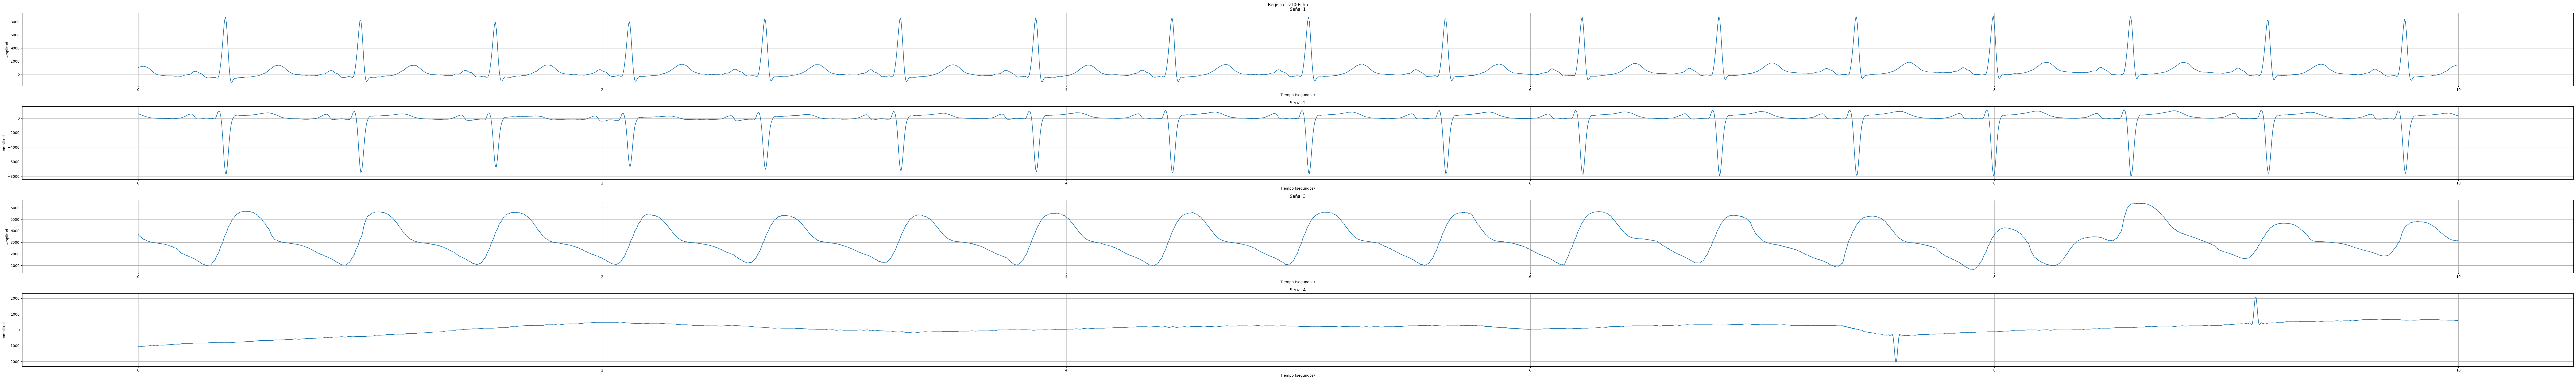

In [17]:
registro_indice = 0
print("Dimensiones de las señales después del procesamiento:", data_first_part[registro_indice].shape)

data_first_part[registro_indice]


nombre_registro = sorted_file_list_h5[registro_indice]
signals = data_first_part[registro_indice]
tiempo = np.arange(0, len(signals[0])) / 250.0

# Grafica cada señal
plt.figure(figsize=(100,15))
plt.suptitle("Registro: " + nombre_registro)

# Señal 1
plt.subplot(4, 1, 1)
plt.plot(tiempo, signals[0])
plt.title("Señal 1")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 2
plt.subplot(4, 1, 2)
plt.plot(tiempo, signals[1])
plt.title("Señal 2")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 3
plt.subplot(4, 1, 3)
plt.plot(tiempo, signals[2])
plt.title("Señal 3")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


# Señal 3
plt.subplot(4, 1, 4)
plt.plot(tiempo, signals[3])
plt.title("Señal 4")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


plt.tight_layout()

plt.show()


Dimensiones de las señales después del procesamiento: (4, 2500)


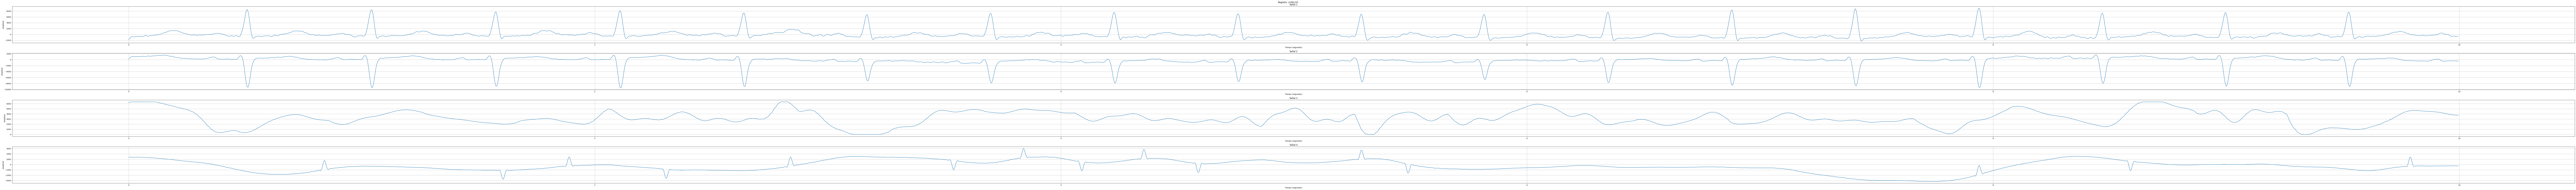

In [18]:
registro_indice = 0
print("Dimensiones de las señales después del procesamiento:", data_second_part[registro_indice].shape)

data_second_part[registro_indice]


nombre_registro = sorted_file_list_h5[registro_indice]
signals = data_second_part[registro_indice]
tiempo = np.arange(0, len(signals[0])) / 250.0

# Grafica cada señal
plt.figure(figsize=(200,15))
plt.suptitle("Registro: " + nombre_registro)

# Señal 1
plt.subplot(4, 1, 1)
plt.plot(tiempo, signals[0])
plt.title("Señal 1")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 2
plt.subplot(4, 1, 2)
plt.plot(tiempo, signals[1])
plt.title("Señal 2")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 3
plt.subplot(4, 1, 3)
plt.plot(tiempo, signals[2])
plt.title("Señal 3")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


# Señal 3
plt.subplot(4, 1, 4)
plt.plot(tiempo, signals[3])
plt.title("Señal 4")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


plt.tight_layout()

plt.show()


###Preprocesamiento de las señales

In [21]:
def normalize_signals(signals):
    # Calcular la media y la desviación estándar de cada señal
    mean = np.mean(signals, axis=1, keepdims=True)
    std = np.std(signals, axis=1, keepdims=True)

    # Encontrar señales que son completamente cero o tienen desviación estándar cero
    zero_signals = np.all(signals == 0, axis=1, keepdims=True)
    zero_std_signals = (std == 0)

    # Dejar en cero las señales con desviación estándar cero
    signals_with_zero_std = np.where(zero_std_signals, 0, signals)

    # Realizar la normalización Z-score independiente para señales que no son constantes
    normalized_signals = np.where(zero_signals | zero_std_signals, signals_with_zero_std, (signals_with_zero_std - mean) / std)

    return normalized_signals

In [22]:
# Aplicar la normalización a todas las señales en all_data_H5 TODOS LOS DATOS
for index, signals in enumerate(data_first_part):
    data_first_part[index] = normalize_signals(signals)


<ipython-input-21-3752ae45e5a7>:14: RuntimeWarning: invalid value encountered in divide
  normalized_signals = np.where(zero_signals | zero_std_signals, signals_with_zero_std, (signals_with_zero_std - mean) / std)
<ipython-input-21-3752ae45e5a7>:14: RuntimeWarning: divide by zero encountered in divide
  normalized_signals = np.where(zero_signals | zero_std_signals, signals_with_zero_std, (signals_with_zero_std - mean) / std)


In [23]:
# Aplicar la normalización a todas las señales en all_data_H5 TODOS LOS DATOS
for index, signals in enumerate(data_second_part):
    data_second_part[index] = normalize_signals(signals)


<ipython-input-21-3752ae45e5a7>:14: RuntimeWarning: invalid value encountered in divide
  normalized_signals = np.where(zero_signals | zero_std_signals, signals_with_zero_std, (signals_with_zero_std - mean) / std)
<ipython-input-21-3752ae45e5a7>:14: RuntimeWarning: divide by zero encountered in divide
  normalized_signals = np.where(zero_signals | zero_std_signals, signals_with_zero_std, (signals_with_zero_std - mean) / std)


In [24]:
print(np.shape(data_first_part))
print(np.shape(data_second_part))

(750, 4, 2500)
(750, 4, 2500)


VISUALIZACIÓN DE DATA SEGMENTADA 1 POST PREPROCESAMIENTO

Dimensiones de las señales después del procesamiento: (4, 2500)


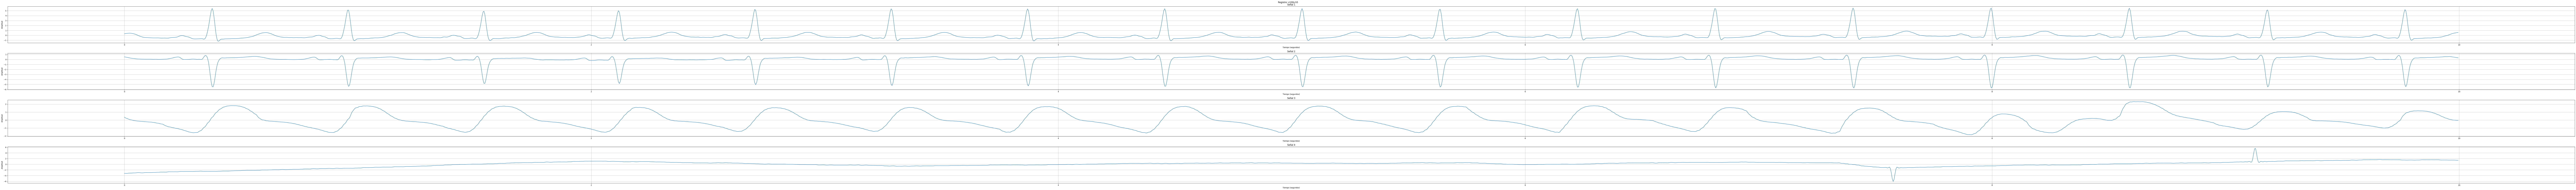

In [25]:
registro_indice = 0
print("Dimensiones de las señales después del procesamiento:", data_first_part[registro_indice].shape)

data_first_part[registro_indice]


nombre_registro = sorted_file_list_h5[registro_indice]
signals = data_first_part[registro_indice]
tiempo = np.arange(0, len(signals[0])) / 250.0

# Grafica cada señal
plt.figure(figsize=(200,15))
plt.suptitle("Registro: " + nombre_registro)

# Señal 1
plt.subplot(4, 1, 1)
plt.plot(tiempo, signals[0])
plt.title("Señal 1")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 2
plt.subplot(4, 1, 2)
plt.plot(tiempo, signals[1])
plt.title("Señal 2")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 3
plt.subplot(4, 1, 3)
plt.plot(tiempo, signals[2])
plt.title("Señal 3")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


# Señal 3
plt.subplot(4, 1, 4)
plt.plot(tiempo, signals[3])
plt.title("Señal 4")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


plt.tight_layout()

plt.show()


VISUALIZACIÓN DE DATA SEGMENTADA 2 POST PREPROCESAMIENTO

Dimensiones de las señales después del procesamiento: (4, 2500)


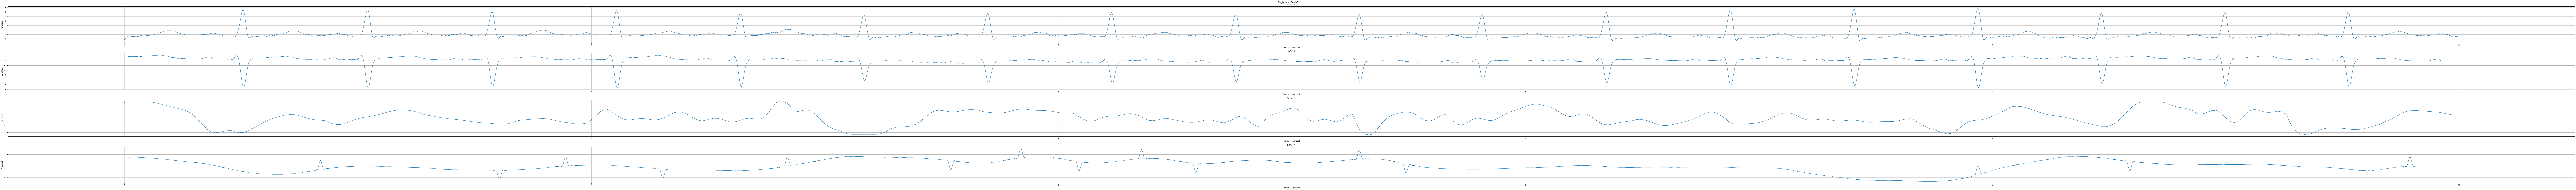

In [26]:
registro_indice = 0
print("Dimensiones de las señales después del procesamiento:", data_second_part[registro_indice].shape)

data_second_part[registro_indice]


nombre_registro = sorted_file_list_h5[registro_indice]
signals = data_second_part[registro_indice]
tiempo = np.arange(0, len(signals[0])) / 250.0

# Grafica cada señal
plt.figure(figsize=(200,15))
plt.suptitle("Registro: " + nombre_registro)

# Señal 1
plt.subplot(4, 1, 1)
plt.plot(tiempo, signals[0])
plt.title("Señal 1")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 2
plt.subplot(4, 1, 2)
plt.plot(tiempo, signals[1])
plt.title("Señal 2")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal 3
plt.subplot(4, 1, 3)
plt.plot(tiempo, signals[2])
plt.title("Señal 3")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


# Señal 3
plt.subplot(4, 1, 4)
plt.plot(tiempo, signals[3])
plt.title("Señal 4")
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')
plt.grid(True)


plt.tight_layout()

plt.show()


###Subdivisión para entrenamiento, validación y testeo

In [ ]:
#Cargando el archivo ALARM
file_path_ALARM = "/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales normales/Archivos Importantes/ALARMS"

In [ ]:
all_data_hea = []

# Procesar archivos .hea
for file_path in sorted_file_paths_hea:
    try:
        # Cargar el encabezado del archivo .hea
        record = wfdb.rdheader(file_path)

        # Crear un diccionario con la información del encabezado
        header_info = {
            "record_name": record.record_name,
            "n_sig": record.n_sig,
            "fs": record.fs,
            "counter_freq": record.counter_freq,
            "base_counter": record.base_counter,
            "sig_len": record.sig_len,
            "base_time": record.base_time,
            "base_date": record.base_date,
            "comments": record.comments,
            "sig_name": record.sig_name,
            "file_name": record.file_name,
            "fmt": record.fmt,
            "samps_per_frame": record.samps_per_frame,
            "skew": record.skew,
            "byte_offset": record.byte_offset,
            "adc_gain": record.adc_gain,
            "baseline": record.baseline,
            "units": record.units,
            "adc_res": record.adc_res,
            "adc_zero": record.adc_zero,
            "init_value": record.init_value,
            "checksum": record.checksum,
            "block_size": record.block_size
        }

        # Agregar la información del encabezado a la lista de datos
        all_data_hea.append(header_info)

    except Exception as e:
        print(f"Error al procesar {file_path}: {str(e)}")

# Verificar el número de datos
print("Número de encabezados procesados:", len(all_data_hea))

Número de encabezados procesados: 750


In [ ]:
# Lista para almacenar los nombres de registro y sus sig_name
all_sig_names = []

# Obtener los nombres de registro y sus sig_name para cada registro
for record_info in all_data_hea:
    record_name = record_info["record_name"]
    sig_names = record_info["sig_name"]
    record_sig_names = {"record_name": record_name, "sig_names": sig_names}
    all_sig_names.append(record_sig_names)

# Imprimir el tamaño de la lista
print("El tamaño de la lista es:", len(all_sig_names))

El tamaño de la lista es: 750


In [ ]:
# Inicializar un diccionario para almacenar las etiquetas binarias directamente con el nombre del registro como clave
label_dict_ALL = {}

# Leer el archivo de alarmas
with open(file_path_ALARM, 'r') as file:
    lines = file.readlines()
    for line in lines:
        parts = line.strip().split(',')
        signal_name = parts[0]  # Nombre de la señal sin .mat

        # Verificar si el nombre de la señal está en la lista de todos los registros procesados
        matching_record = next((record for record in all_sig_names if record["record_name"] == signal_name), None)
        if matching_record is not None:
            label = int(parts[2])  # Etiqueta binaria (0 o 1)
            label_dict_ALL[matching_record["record_name"]] = label

# Verificar el resultado
print("Diccionario de etiquetas binarias:")
print(label_dict_ALL)


Diccionario de etiquetas binarias:
{'v100s': 0, 'v101l': 0, 'v102s': 0, 'a103l': 0, 'a104s': 0, 'a105l': 0, 't106s': 1, 't107l': 1, 't108s': 1, 'a109l': 0, 't110s': 1, 'v111l': 0, 't112s': 1, 'v113l': 0, 't114s': 1, 'v115l': 0, 't116s': 0, 't117l': 1, 't118s': 1, 'v119l': 0, 'f120s': 0, 'f121l': 0, 'v122s': 0, 'a123l': 0, 'b124s': 1, 'b125l': 1, 'b126s': 1, 'v127l': 0, 'v128s': 0, 'f129l': 0, 'f130s': 0, 'v131l': 1, 'v132s': 1, 'v133l': 1, 'a134s': 0, 'v135l': 0, 'v136s': 0, 'f137l': 0, 'f138s': 0, 'v139l': 1, 'v140s': 0, 'v141l': 0, 'a142s': 1, 'v143l': 1, 'f144s': 0, 'a145l': 0, 'v146s': 0, 'v147l': 0, 'v148s': 0, 't149l': 1, 't150s': 1, 't151l': 1, 'a152s': 0, 'v153l': 0, 'v154s': 0, 'v155l': 0, 't156s': 1, 't157l': 1, 'v158s': 1, 'v159l': 1, 'v160s': 0, 'a161l': 1, 'v162s': 0, 'a163l': 0, 'v164s': 0, 'a165l': 0, 'v166s': 0, 'a167l': 1, 'v168s': 0, 'v169l': 0, 'a170s': 0, 'a171l': 0, 'a172s': 1, 't173l': 1, 't174s': 1, 't175l': 1, 'v176s': 0, 'v177l': 0, 'a178s': 0, 'v179l': 0, 'v18

In [ ]:
# Obtener los nombres de las señales procesadas
signal_names_ALL = [os.path.splitext(os.path.basename(file))[0] for file in sorted_file_paths_h5]

# Filtrar solo los nombres de señales procesados
processed_signal_names_ALL = [name for name in signal_names_ALL if name in signal_names_ALL]

# Dividir los nombres de las señales procesadas en conjuntos de entrenamiento, validación y prueba
train_names_ALL, temp_names = train_test_split(processed_signal_names_ALL, test_size=0.2, random_state=42)
val_names_ALL, test_names_ALL = train_test_split(temp_names, test_size=0.5, random_state=42)

# Imprimir nombres de las señales de entrenamiento, validación y prueba
print("Nombres de señales de entrenamiento:")
print(train_names_ALL)
print("\nNombres de señales de validación:")
print(val_names_ALL)
print("\nNombres de señales de prueba:")
print(test_names_ALL)

Nombres de señales de entrenamiento:
['b695l', 'b231l', 'f144s', 'a170s', 'v772s', 'b308s', 't444s', 'a723l', 't235l', 'v581l', 'v128s', 'v564s', 'v498s', 'v729l', 'f236s', 't595l', 't106s', 'v711l', 't173l', 'v298s', 'b299l', 'v245l', 'v423l', 'v844s', 'v232s', 'v426s', 'a715l', 't801l', 'v141l', 't208s', 'v632s', 't156s', 'v292s', 't683l', 'b456s', 'v701l', 't477l', 'b124s', 'f657l', 't580s', 'v551l', 'v432s', 'v830s', 'v210s', 'v182s', 't151l', 't520s', 't702s', 't622s', 'f697l', 'v726s', 'a490s', 'a239l', 'v767l', 'v536s', 't118s', 't731l', 't240s', 'a446s', 'v607l', 'b183l', 'a161l', 'v721l', 'f545l', 'f129l', 'a631l', 'b331l', 'f450s', 'v392s', 'v831l', 'v282s', 'b669l', 'v364s', 'v848s', 'v323l', 'v482s', 't507l', 't335l', 'a556s', 'v309l', 'b488s', 'f529l', 't276s', 't787l', 'f414s', 'v375l', 'v648s', 'v460s', 'f237l', 't707l', 'a802s', 'b764s', 't263l', 'v438s', 'v759l', 't174s', 'v431l', 'v686s', 't344s', 'v427l', 'b451l', 'a582s', 'v204s', 't214s', 'v774s', 't394s', 't689l',

In [ ]:
print("Cantidad de datos de Entrenamiento:", len(train_names_ALL))
print("Cantidad de datos de Validación:", len(val_names_ALL))
print("Cantidad de datos de Testeo:", len(test_names_ALL))

Cantidad de datos de Entrenamiento: 600
Cantidad de datos de Validación: 75
Cantidad de datos de Testeo: 75


In [ ]:
# Obtener las etiquetas binarias para las señales de entrenamiento, validación y prueba
train_labels_ALL = [label_dict_ALL[name] for name in train_names_ALL]
val_labels_ALL = [label_dict_ALL[name] for name in val_names_ALL]
test_labels_ALL = [label_dict_ALL[name] for name in test_names_ALL]

# Contar la cantidad de 0 y 1 para cada conjunto
count_train_ALL_0 = np.sum(np.array(train_labels_ALL) == 0)
count_train_ALL_1 = np.sum(np.array(train_labels_ALL) == 1)

count_val_ALL_0 = np.sum(np.array(val_labels_ALL) == 0)
count_val_ALL_1 = np.sum(np.array(val_labels_ALL) == 1)

count_test_ALL_0 = np.sum(np.array(test_labels_ALL) == 0)
count_test_ALL_1 = np.sum(np.array(test_labels_ALL) == 1)

# Crear un DataFrame
data_split_ALL = {'Conjunto': ['Entrenamiento', 'Validación', 'Testeo'],
                 'Falsas Alarmas (0)': [count_train_ALL_0, count_val_ALL_0, count_test_ALL_0],
                 'Verdaderas Alarmas (1)': [count_train_ALL_1, count_val_ALL_1, count_test_ALL_1]}

df_split_ALL = pd.DataFrame(data_split_ALL)

# Mostrar la tabla
display(df_split_ALL)

Conjunto  Falsas Alarmas (0)  Verdaderas Alarmas (1)
0  Entrenamiento                 358                     242
1     Validación                  52                      23
2         Testeo                  46                      29

In [ ]:
# Función para obtener datos y etiquetas
def get_data_and_labels_ALL(names, all_data_h5_ALL, label_dict_ALL):
    data = []
    labels = []
    for name in names:
        data.append(all_data_h5_ALL[processed_signal_names_ALL.index(name)])
        labels.append(label_dict_ALL.get(name, -1))  # -1 si el nombre no tiene etiqueta
    return np.array(data), np.array(labels)

In [ ]:
# Obtener datos y etiquetas para conjuntos de entrenamiento, validación y prueba
XtrainALL1, ytrainALL1 = get_data_and_labels_ALL(train_names_ALL, data_first_part, label_dict_ALL)
XvalALL1, yvalALL1 = get_data_and_labels_ALL(val_names_ALL, data_first_part, label_dict_ALL)
XtestALL1, ytestALL1 = get_data_and_labels_ALL(test_names_ALL, data_first_part, label_dict_ALL)


In [ ]:
print("Tamaño de Xtrain:", XtrainALL1.shape)
print("Tamaño de ytrain:", ytrainALL1.shape)
print("----------------")
print("Tamaño de Xval:", XvalALL1.shape)
print("Tamaño de yval", yvalALL1.shape)
print("----------------")
print("Tamaño de Xtest:", XtestALL1.shape)
print("Tamaño de ytest:", ytestALL1.shape)

Tamaño de Xtrain: (600, 4, 67500)
Tamaño de ytrain: (600,)
----------------
Tamaño de Xval: (75, 4, 67500)
Tamaño de yval (75,)
----------------
Tamaño de Xtest: (75, 4, 67500)
Tamaño de ytest: (75,)


In [ ]:
#Hago un reshape para que la señal se ajuste a la entrada del modelo
X_trainALL1 = np.transpose(XtrainALL1, (0, 2, 1))
X_valALL1 = np.transpose(XvalALL1, (0, 2, 1))
X_testALL1 = np.transpose(XtestALL1, (0, 2, 1))
#Hago el mismo reshape para los labels
y_trainALL1 = ytrainALL1.reshape(-1, 1)
y_valALL1 = yvalALL1.reshape(-1, 1)
y_testALL1 = ytestALL1.reshape(-1, 1)

In [ ]:
print("Tamaño de X_train:", X_trainALL1.shape)
print("Tamaño de y_train:", y_trainALL1.shape)
print("-----------------")
print("Tamaño de X_val:", X_valALL1.shape)
print("Tamaño de y_val:", y_valALL1.shape)
print("-----------------")
print("Tamaño de X_test:", X_testALL1.shape)
print("Tamaño de y_test:", y_testALL1.shape)

Tamaño de X_train: (600, 67500, 4)
Tamaño de y_train: (600, 1)
-----------------
Tamaño de X_val: (75, 67500, 4)
Tamaño de y_val: (75, 1)
-----------------
Tamaño de X_test: (75, 67500, 4)
Tamaño de y_test: (75, 1)


In [ ]:
# Obtener datos y etiquetas para conjuntos de entrenamiento, validación y prueba
XtrainALL2, ytrainALL2 = get_data_and_labels_ALL(train_names_ALL, data_second_part, label_dict_ALL)
XvalALL2, yvalALL2 = get_data_and_labels_ALL(val_names_ALL, data_second_part, label_dict_ALL)
XtestALL2, ytestALL2 = get_data_and_labels_ALL(test_names_ALL, data_second_part, label_dict_ALL)


In [ ]:
print("Tamaño de Xtrain:", XtrainALL2.shape)
print("Tamaño de ytrain:", ytrainALL2.shape)
print("----------------")
print("Tamaño de Xval:", XvalALL2.shape)
print("Tamaño de yval", yvalALL2.shape)
print("----------------")
print("Tamaño de Xtest:", XtestALL2.shape)
print("Tamaño de ytest:", ytestALL2.shape)

Tamaño de Xtrain: (600, 4, 7500)
Tamaño de ytrain: (600,)
----------------
Tamaño de Xval: (75, 4, 7500)
Tamaño de yval (75,)
----------------
Tamaño de Xtest: (75, 4, 7500)
Tamaño de ytest: (75,)


In [ ]:
#Hago un reshape para que la señal se ajuste a la entrada del modelo
X_trainALL2 = np.transpose(XtrainALL2, (0, 2, 1))
X_valALL2 = np.transpose(XvalALL2, (0, 2, 1))
X_testALL2 = np.transpose(XtestALL2, (0, 2, 1))
#Hago el mismo reshape para los labels
y_trainALL2 = ytrainALL2.reshape(-1, 1)
y_valALL2 = yvalALL2.reshape(-1, 1)
y_testALL2 = ytestALL2.reshape(-1, 1)

In [ ]:
print("Tamaño de X_train:", X_trainALL2.shape)
print("Tamaño de y_train:", y_trainALL2.shape)
print("-----------------")
print("Tamaño de X_val:", X_valALL2.shape)
print("Tamaño de y_val:", y_valALL2.shape)
print("-----------------")
print("Tamaño de X_test:", X_testALL2.shape)
print("Tamaño de y_test:", y_testALL2.shape)

Tamaño de X_train: (600, 7500, 4)
Tamaño de y_train: (600, 1)
-----------------
Tamaño de X_val: (75, 7500, 4)
Tamaño de y_val: (75, 1)
-----------------
Tamaño de X_test: (75, 7500, 4)
Tamaño de y_test: (75, 1)


####Modelos de inteligencia artificial

In [ ]:
#PRIMERA RED, ENTRADA DE 67500

samples_per_signal = 67500
num_of_signals = 4


# Definir el valor de regularización L2
l2_reg = 0.0005

input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = layers.Dropout(0.85)(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = layers.Dropout(0.85)(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = layers.Dropout(0.85)(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = layers.Dropout(0.85)(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(l2_reg))(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 67500, 4)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 67500, 4)             16        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 13500, 64)            12864     ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 13500, 64)            25664     ['batch_normaliza

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_trainALL1, X_valALL1), axis=0)
y_combined = np.concatenate((y_trainALL1, y_valALL1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_FSP_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_FSP_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_testALL1, y_testALL1)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)

    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_testALL1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_testALL1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')

In [ ]:
#SEGUNDA RED, ENTRADA DE 7500

samples_per_signal = 7500
num_of_signals = 4


# Definir el valor de regularización L2
l2_reg = 0.0005

input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = layers.Dropout(0.85)(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = layers.Dropout(0.85)(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = layers.Dropout(0.85)(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = layers.Dropout(0.85)(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(l2_reg))(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_trainALL2, X_valALL2), axis=0)
y_combined = np.concatenate((y_trainALL2, y_valALL2), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_SSP_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_SSP_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_testALL2, y_testALL2)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)

    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_testALL2)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_testALL2 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')